# Scratchpad for testing out graphlab with project data

In [1]:
import json
import numpy as np
import graphlab as gl
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

This non-commercial license of GraphLab Create is assigned to windsurf_dean@yahoo.com and will expire on May 26, 2017. For commercial licensing options, visit https://dato.com/buy/.


[INFO] graphlab.cython.cy_server: GraphLab Create v1.10.1 started. Logging: /tmp/graphlab_server_1467796115.log


In [ ]:
gl.__VERSION__

## Load in user-item-rating data...

In [ ]:
# create Pandas DF with data pulled from Postgres (restaurant only reviews)
df = pd.read_csv('data_analysis/user_reviews.csv', header=None,
                 names=['user_id', 'business_id', 'business_name', 'stars', 'locale'])

In [ ]:
df.head(5)

In [ ]:
df.to_csv('reviews.csv', columns=['user_id','business_id','stars'])

In [ ]:
df.groupby(['user_id', 'business_id', 'stars']).count()

Try loading directly into graphlab...

In [2]:
sf_obs1 = gl.SFrame.read_csv('data_analysis/user_reviews.csv', usecols=['user_id', 'business_id', 'stars'])

Finished parsing file /Volumes/Macintosh_HD/Users/deanliu/git/Galvanize/capstone_project/traveler_eats_recommender/data_analysis/user_reviews.csv

Parsing completed. Parsed 100 lines in 0.879659 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 1092266 lines. Lines per second: 1.04637e+06

Finished parsing file /Volumes/Macintosh_HD/Users/deanliu/git/Galvanize/capstone_project/traveler_eats_recommender/data_analysis/user_reviews.csv

Parsing completed. Parsed 1363242 lines in 1.17078 secs.

In [ ]:
sf_obs1.head()

In [ ]:
# store the observation data in Graphlab's SFrame type
sf_obs = gl.SFrame(df[['user_id', 'business_id', 'stars']])

In [ ]:
sf_obs.head(5)

In [ ]:
sf_obs.num_rows()

## Test loading business json data

In [3]:
fname_test = 'data_analysis/test_data/test100_business.json'
fname_full = '../data/Yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json'
# 'data_analysis/full_data/yelp_academic_dataset_business.json'

fname = fname_full # user full dataset
# fname = fname_test # user small test dataset
with open(fname) as js_file:
    js_list = [json.loads(js_line) for js_line in js_file]
    js_list_filtered = [js for js in js_list if 'Restaurants' in js['categories']]
    dfb = pd.DataFrame(js_list_filtered)


In [ ]:
dfb.head(2)

In [4]:
dfbi = dfb.set_index('business_id')

In [5]:
dfbi.head(2)

,attributes,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
business_id,,,,,,,,,,,,,,
5UmKMjUEUNdYWqANhGckJw,"{u'Take-out': True, u'Drive-Thru': False, u'Ou...","[Fast Food, Restaurants]",Dravosburg,"4734 Lebanon Church Rd\nDravosburg, PA 15034","{u'Tuesday': {u'close': u'21:00', u'open': u'1...",40.354327,-79.900706,Mr Hoagie,[],True,4,4.5,PA,business
mVHrayjG3uZ_RLHkLj-AMg,"{u'Alcohol': u'full_bar', u'Noise Level': u'av...","[Bars, American (New), Nightlife, Lounges, Res...",rankin,"414 Hawkins Ave\nrankin, PA 15104","{u'Tuesday': {u'close': u'19:00', u'open': u'1...",40.413464,-79.880247,Emil's Lounge,[],True,20,5.0,PA,business


In [14]:
biz = dfbi.ix['0i0PwU8lpj4evYKQogWxcA']
print biz.categories
biz

[u'Gastropubs', u'Restaurants']


attributes       {u'Take-out': True, u'Accepts Credit Cards': T...
categories                               [Gastropubs, Restaurants]
city                                                     Las Vegas
full_address     The Grand Canal Shoppes at the Venetian\n3355 ...
hours            {u'Monday': {u'close': u'23:00', u'open': u'11...
latitude                                                   36.1215
longitude                                                  -115.17
name                                                  Public House
neighborhoods                                          [The Strip]
open                                                          True
review_count                                                   503
stars                                                          3.5
state                                                           NV
type                                                      business
Name: 0i0PwU8lpj4evYKQogWxcA, dtype: object

# Quick EDA

## Group reviews by users...

In [6]:
sf_obs = sf_obs1

In [7]:
# number of reviews by user (388k distinct users)
review_count_by_user = sf_obs.groupby('user_id', [gl.aggregate.COUNT()]).sort('Count', ascending=False)#['Count']
review_count_by_user[0:5]

user_id,Count
DrWLhrK8WMZf7Jb-Oqc7ww,817
9A2-wSoBUxlMd3LwmlGrrQ,782
3gIfcQq5KxAegwCPXc83cQ,754
Iu3Jo9ROp2IWC9FwtWOaUQ,666
kGgAARL2UmvCcTRfiscjug,665


In [5]:
review_count_by_user.filter_by('DrWLhrK8WMZf7Jb-Oqc7ww', 'user_id')

user_id,Count
DrWLhrK8WMZf7Jb-Oqc7ww,817


In [8]:
# how many times have the same user reviewed the same restaurant?
unique_user_items = sf_obs.groupby(['user_id', 'business_id'],
                                   {'count': gl.aggregate.COUNT(),
                                    'avg_rating': gl.aggregate.AVG('stars'),
                                    'ratings': gl.aggregate.CONCAT('stars')}) \
                          .sort('count', ascending=False)

unique_user_items.head(5)

business_id,user_id,count,ratings,avg_rating
T1jYZFB_7cqdhuvzpxfFWQ,q200TCFOheJfS_MvvwMfJw,29,"[3, 3, 2, 3, 4, 4, 3, 3,3, 4, 3, 3, 3, 3, 2, 2, ...",3.13793103448
6LoNRotewF81fxka6L_8Jw,q200TCFOheJfS_MvvwMfJw,19,"[4, 5, 3, 5, 4, 5, 3, 3,5, 5, 5, 5, 5, 5, 5, 5, ...",4.57894736842
8aPTQeDYOMNEu907WfflCQ,_Q4Ks28-Jks-TjFT-YXw_A,18,"[4, 4, 4, 4, 4, 5, 4, 4,4, 3, 5, 4, 4, 4, 4, 4, ...",4.05555555556
yumgsa9m02CACzq0dHZP7Q,q200TCFOheJfS_MvvwMfJw,18,"[3, 4, 4, 4, 4, 4, 4, 3,3, 4, 4, 3, 3, 5, 2, 4, ...",3.55555555556
iaEqryy7OwAOAQkLWDBquQ,kG8jkVFgOAOq6Ht6RvAjEQ,14,"[5, 5, 4, 4, 5, 5, 5, 5,5, 5, 5, 5, 5, 5] ...",4.85714285714


In [7]:
unique_user_items.filter_by('DrWLhrK8WMZf7Jb-Oqc7ww', 'user_id')

business_id,user_id,count,ratings,avg_rating
rVUEZpHQfWI_3kt0lBwaxQ,DrWLhrK8WMZf7Jb-Oqc7ww,5,"[4, 4, 4, 4, 4]",4.0
vMeO4qFGHvu8ZyMsH0LDdw,DrWLhrK8WMZf7Jb-Oqc7ww,5,"[3, 4, 1, 3, 2]",2.6
aLMStInNBczJKtIJFMlwJA,DrWLhrK8WMZf7Jb-Oqc7ww,5,"[4, 4, 4, 4, 3]",3.8
ytpmoIty7loFB8kRYRtJHw,DrWLhrK8WMZf7Jb-Oqc7ww,4,"[5, 5, 5, 4]",4.75
ymSMV5wMjFwcusoGRaqDWA,DrWLhrK8WMZf7Jb-Oqc7ww,4,"[4, 2, 4, 5]",3.75
z3yFuLVrmH-3RJruPEMYKw,DrWLhrK8WMZf7Jb-Oqc7ww,4,"[3, 3, 1, 3]",2.5
9SKdOoDHcFoxK5ZtsgHJoA,DrWLhrK8WMZf7Jb-Oqc7ww,4,"[3, 4, 2, 3]",3.0
Q8OMwgekiTtgClSiRcQcSw,DrWLhrK8WMZf7Jb-Oqc7ww,4,"[3, 3, 4, 3]",3.25
n6Zz_KdxcUou8b2MSoz2tw,DrWLhrK8WMZf7Jb-Oqc7ww,4,"[3, 3, 3, 3]",3.0
v7OwbHgNgy_VQ9eP5FjvUA,DrWLhrK8WMZf7Jb-Oqc7ww,4,"[5, 5, 3, 4]",4.25


In [9]:
# group reviews by users, against distinct restaurants.
# Some users reviewed same restaurants multiple times!!!
restaurants_by_user = unique_user_items.groupby('user_id',
                                                {'count':gl.aggregate.COUNT(),
                                                 'restaurants':gl.aggregate.CONCAT('business_id','avg_rating')}) \
                                       .sort('count', ascending=False)
restaurants_by_user.head(5)

user_id,count,restaurants
9A2-wSoBUxlMd3LwmlGrrQ,768,"{'IjhfUYq7ipHUfm8GeMTJnA': 3.0, ..."
3gIfcQq5KxAegwCPXc83cQ,688,"{'rZbHg4ACfN3iShdsT47WKQ': 4.0, ..."
DrWLhrK8WMZf7Jb-Oqc7ww,637,"{'rZbHg4ACfN3iShdsT47WKQ': 1.0, ..."
Iu3Jo9ROp2IWC9FwtWOaUQ,618,"{'3w5gd4EuSc75UKYMJiNUPA': 5.0, ..."
kGgAARL2UmvCcTRfiscjug,600,"{'Shy4HqmyEewCLvq7Ub3Whg': 3.0, ..."


In [9]:
biz_rating_dict = restaurants_by_user.filter_by('0MRlubaLu5v3sI4vu_XqDg', 'user_id')[0]['restaurants']

In [10]:
biz_rating_dict.get('Mm8x_jzeLrWlvDEnqhuCBQ')

4.0

In [ ]:
sorted(biz_rating_dict, key=biz_rating_dict.get)

In [ ]:
biz_rating_dict.pop('2mKC1oXdGCl2w8SAZK8fjw',0)

In [ ]:
for key in biz_rating_dict.iterkeys():# keys()
    print key

In [11]:
restaurants_by_user.filter_by('DrWLhrK8WMZf7Jb-Oqc7ww', 'user_id')

user_id,count,restaurants
DrWLhrK8WMZf7Jb-Oqc7ww,637,"{'rZbHg4ACfN3iShdsT47WKQ': 1.0, ..."


### Save file 'restaurants_by_user.json'

In [ ]:
# json file
restaurants_by_user.export_json('restaurants_by_user.json', orient='records')

In [ ]:
# csv file
restaurants_by_user.export_csv('restaurants_by_user.csv')

In [ ]:
restaurants_by_user.num_rows()

## Plots

In [17]:
matplotlib.rcParams.update({'font.size':22})

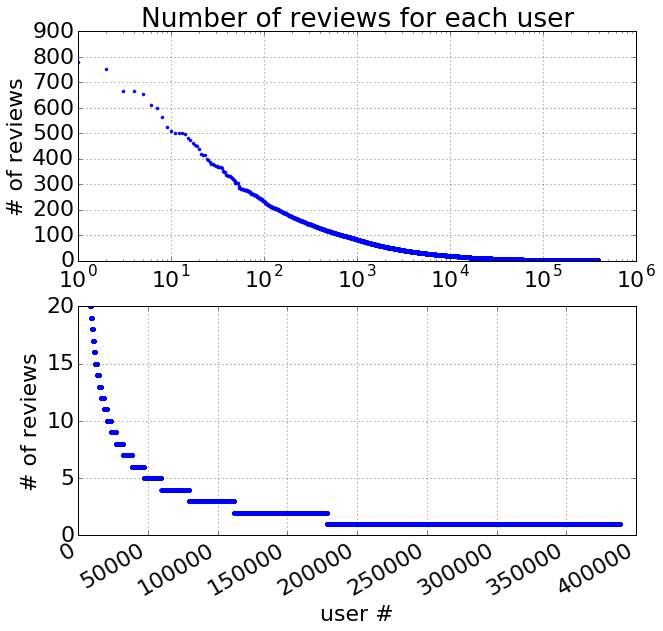

In [48]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(2,1,2)
plt.plot(review_count_by_user['Count'], '.');
plt.grid()
plt.ylim([0,20])
plt.xlabel('user #')
plt.ylabel('# of reviews')
# plt.title('Number of reviews for each user')
fig.autofmt_xdate()

fig.add_subplot(2,1,1)
plt.semilogx(review_count_by_user['Count'], '.');
plt.grid()
# plt.xlabel('user #')
plt.ylabel('# of reviews')
plt.title('Number of reviews for each user')

plt.savefig('user-reviews plot.png', format='png')
plt.show()

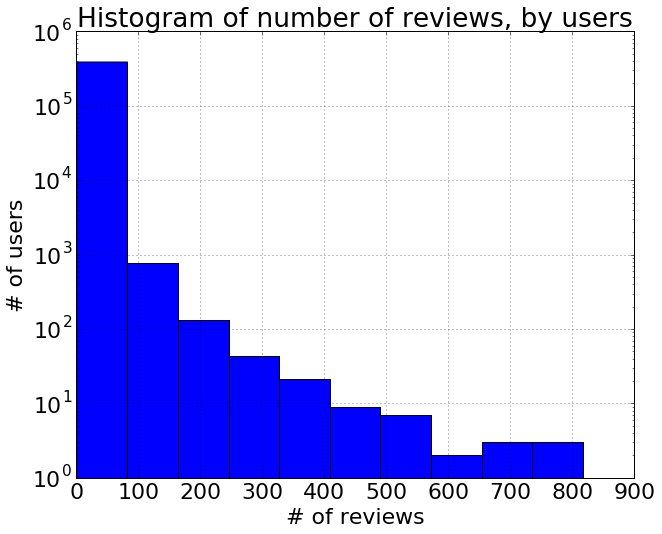

In [23]:
plt.figure(figsize=(10,8))
plt.hist(review_count_by_user['Count'], log=True, cumulative=False);
plt.grid()
plt.xlabel('# of reviews')
plt.ylabel('# of users')
plt.title('Histogram of number of reviews, by users')

## Group reviews by restaurants...

In [ ]:
# number of reviews by restaurant (25k distinct restaurants)
review_count_by_biz = sf_obs.groupby('business_id', [gl.aggregate.COUNT()]).sort('Count', ascending=False)
review_count_by_biz[0:10]

In [ ]:
plt.figure(figsize=(10,8))
plt.semilogx(review_count_by_biz['Count'], '.');
plt.grid()
plt.xlabel('business')
plt.ylabel('# of reviews')
plt.title('Plot of number of reviews, by business')

In [ ]:
plt.figure(figsize=(10,8))
plt.loglog(review_count_by_biz['Count'], '.');
plt.grid()
plt.xlabel('business')
plt.ylabel('# of reviews')
plt.title('Log-Log plot of number of reviews, by business')

In [ ]:
plt.figure(figsize=(10,8))
plt.hist(review_count_by_biz['Count'], log=True);
plt.grid()
plt.autoscale(tight=True)
plt.xlabel('# of reviews')
plt.ylabel('count of biz\n(LOG SCALE!)')
plt.title('(log) Histogram of number of reviews, by business')

## Load in business.json file as 'item_data', for side data factorization...

In [ ]:
from create_sidedata import create_sidedata
sf_itemdata = create_sidedata()

# Setup the train/test data split...

In [ ]:
# split the test data via Graphlab's recommender tailored splitter function
train_set, test_set = gl.recommender.util.random_split_by_user(sf_obs,
                                                               'user_id',
                                                               'business_id',
                                                               max_num_users=100)

# Run the recommender...

In [ ]:
# create the recommender (will train during this step)
rec = gl.recommender.factorization_recommender.create(
            train_set,
            user_id='user_id',
            item_id='business_id',
            target='stars',
#             item_data=sf_itemdata
            )

#### Save off the model

In [ ]:
rec.save('frec_without_sides')


In [ ]:
pwd

# Load the model from disk

In [ ]:
mws = gl.load_model('models/frec_with_sides')
mwos= gl.load_model('models/frec_without_sides')

# mws = gl.load_model('models/frec_tmp_ws')
# mwos= gl.load_model('models/frec_tmp_wos')

In [ ]:
'Restaurants' in mws.item_side_data_column_names

In [ ]:
import random

In [ ]:
# create a test users
threshold_lo = 5
threshold_hi = 10
test_user = restaurants_by_user[(threshold_lo<restaurants_by_user['count']) &
                                (restaurants_by_user['count']<threshold_hi)] \
                .sample(0.01)[0:1]
print test_user

In [ ]:
print test_user[0]

In [ ]:
test_user[0]['user_id']

In [ ]:
simuser_ws = mws.get_similar_users([test_user[0]['user_id']], k=10)
simuser_wsj = simuser_ws.join(restaurants_by_user, on={'similar':'user_id'}, how='left').sort('rank')
simuser_wsj[['restaurants']][0]

In [ ]:
simuser_ns = mwos.get_similar_users([test_user[0]['user_id']], k=10)
simuser_nsj = simuser_ns.join(restaurants_by_user, on={'similar':'user_id'}, how='left').sort('rank')
print simuser_nsj.head()

In [ ]:
simuser_ns_sim = simuser_ns['similar']

In [ ]:
simuser_ns_sim

In [ ]:
for user in list(simuser_ns['similar'])[::-1]:
    print user

In [ ]:
restaurants_by_user.filter_by('M24Y07AyCR8hdlC3qMBNDQ', 'user_id')

In [ ]:
restaurants_by_user.head(2)

In [ ]:
mws.show()
mwos.show()

In [ ]:
list(simuser_ws['similar','score'][0:5])

In [ ]:
simuser_ws

In [ ]:
# rec = gl.recommender.create(
#             sf_obj,
#             user_id='user_id',
#             item_id='business_id',
#             target ='stars')

In [ ]:
# evaluate 1 datapoint (user=1, business=100) for potential rating
one_datapoint_sf = gl.SFrame({'user_id': [1], 'business_id': [100]})
print "stars:", rec.predict(one_datapoint_sf)[0]   # 4.879

In [ ]:
rec.get('coefficients')['intercept']

In [ ]:
# rec['coefficients']  # equivalent to: rec.get('coefficients')
rec.get('coefficients')['user_id']

In [ ]:
# rec['coefficients']  # equivalent to: rec.get('coefficients')
rec.get('coefficients')['business_id']

In [ ]:
business_sf = rec['coefficients']['business_id']
print len(business_sf)                     # 1682
print len(business_sf['factors'][0])       # 8
user_sf = rec['coefficients']['user_id']
print len(user_sf)                      # 943
print len(user_sf['factors'][0])        # 8